<a href="https://colab.research.google.com/github/shreyus3003/CMPE297_sec49/blob/master/Assignment_1_%20Part_2/part2_semi_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi supervised Learning
Using semisupervised method, we can label a large amount of data using a few labeled data. We first train the model on the labeled data and the trained model is used to predict the unlabeled data, add the closely predicted data to the labeled set to make more labeled data. 
To illustrate semisupervised learning, we use the MNIST handwritten digits data. 

In [ ]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68503 sha256=3b3229fda3f6810fb9fa6d4ac91f5e4860a57feb5616fc1c0fc8b6dc3c512d5e
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [18]:
# Import the libraries.
%matplotlib inline
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings('ignore')

In [4]:
%cd /content


/content


## Load the data:
Mnist handwritten digits train and test data is loaded 

In [5]:
import pandas as pd 



num_train_samples = 1000
samples_per_class = int(num_train_samples/9)

x = pd.read_csv('/content/drive/My Drive/mnist_train.csv')
y = x['label']
x.drop(['label'], inplace = True, axis = 1)

x_test = pd.read_csv('/content/drive/My Drive/mnist_test.csv')
y_test = x_test['label']
x_test.drop(['label'], inplace = True, axis = 1)

We first divide the dataset such that we have unlabeled sets, we should have equal samples of all 10 classes.



In [6]:
UNLABELED_BS = 256
TRAIN_BS = 32
TEST_BS = 1024

x_train, x_unlabeled = x[y.values == 0].values[:samples_per_class], x[y.values == 0].values[samples_per_class:]
y_train = y[y.values == 0].values[:samples_per_class]

for i in range(1,10):
    x_train = np.concatenate([x_train, x[y.values == i].values[:samples_per_class]], axis = 0)
    y_train = np.concatenate([y_train, y[y.values == i].values[:samples_per_class]], axis = 0)
    
    x_unlabeled = np.concatenate([x_unlabeled, x[y.values == i].values[samples_per_class:]], axis = 0)

Normalize the data, make sure it is converted into tensors, and then we create train, test and unlabeled dataloaders.


In [7]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
x_train = normalizer.fit_transform(x_train)
x_unlabeled = normalizer.transform(x_unlabeled)
x_test = normalizer.transform(x_test.values)

In [8]:
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor) 

In [9]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = TRAIN_BS, shuffle = True, num_workers = 8)

unlabeled_train = torch.from_numpy(x_unlabeled).type(torch.FloatTensor)

unlabeled = torch.utils.data.TensorDataset(unlabeled_train)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled, batch_size = UNLABELED_BS, shuffle = True, num_workers = 8)

test_loader = torch.utils.data.DataLoader(test, batch_size = TEST_BS, shuffle = True, num_workers = 8)

### Model

Let us create a simple model with 2 conv and 2 FC layer with dropouts

In [30]:

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
            self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
            self.conv2_drop = nn.Dropout2d()
            self.fc1 = nn.Linear(640, 150)
            self.fc2 = nn.Linear(150, 10)
            self.log_softmax = nn.LogSoftmax(dim = 1)

        def forward(self, x):
            x = x.view(-1,1,28,28)
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
            x = x.view(-1, 640)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc2(x))
            x = self.log_softmax(x)
            return x
        
net = Net().cuda()

Get the loss and accuracy values by evaluating the model.


In [31]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels.cuda()).sum()
            loss += F.nll_loss(output, labels.cuda()).item()

    return (float(correct)/len(test)) *100, (loss/len(test_loader))

Train the model, with labeled set of data. Run 100 epochs to train the model with 1k labeled data.

In [32]:
from tqdm import tqdm_notebook
def train_supervised(model, train_loader, test_loader):
    optimizer = torch.optim.SGD( model.parameters(), lr = 0.1)
    EPOCHS = 100
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        correct = 0
        running_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            
            output = model(X_batch)
            labeled_loss = F.nll_loss(output, y_batch)
                       
            optimizer.zero_grad()
            labeled_loss.backward()
            optimizer.step()
            running_loss += labeled_loss.item()
        
        if epoch %10 == 0:
            test_acc, test_loss = evaluate(model, test_loader)
            print('Epoch: {} : Train Loss : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, running_loss/(10 * len(train)), test_acc, test_loss))
            model.train()
    

In [33]:
train_supervised(net, train_loader, test_loader)

Epoch: 0 : Train Loss : 0.00727 | Test Acc : 9.74000 | Test Loss : 2.303 
Epoch: 10 : Train Loss : 0.00725 | Test Acc : 10.23000 | Test Loss : 2.300 
Epoch: 20 : Train Loss : 0.00660 | Test Acc : 45.61000 | Test Loss : 1.930 
Epoch: 30 : Train Loss : 0.00177 | Test Acc : 87.48000 | Test Loss : 0.409 
Epoch: 40 : Train Loss : 0.00103 | Test Acc : 91.70000 | Test Loss : 0.255 
Epoch: 50 : Train Loss : 0.00071 | Test Acc : 93.62000 | Test Loss : 0.204 
Epoch: 60 : Train Loss : 0.00057 | Test Acc : 94.23000 | Test Loss : 0.184 
Epoch: 70 : Train Loss : 0.00041 | Test Acc : 94.48000 | Test Loss : 0.182 
Epoch: 80 : Train Loss : 0.00035 | Test Acc : 94.76000 | Test Loss : 0.177 
Epoch: 90 : Train Loss : 0.00022 | Test Acc : 94.93000 | Test Loss : 0.178 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Evaluate the test accuracy and save the model weights for predicting the unlabeled data.

In [ ]:
test_acc, test_loss = evaluate(net, test_loader)
print('Test Acc : {:.5f} | Test Loss : {:.3f} '.format(test_acc, test_loss))
torch.save(net.state_dict(), 'saved_models/supervised_weights')

Test Acc : 94.48000 | Test Loss : 0.194 


In [ ]:
net.load_state_dict(torch.load('/content/saved_models/supervised_weights'))

<All keys matched successfully>

In [ ]:
T1 = 100
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

Initially 100 epochs were trained on labeled data and then 150 epochs trained on semisupervised training.

In [ ]:


from tqdm import tqdm_notebook

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []
def semisup_train(model, train_loader, unlabeled_loader, test_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    EPOCHS = 150
    
    step = 100 
    
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
          
            x_unlabeled = x_unlabeled[0].cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            
         
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.cpu())
                pseudo_label.append(pseudo_labeled.cpu())
       
            
            
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
            
            
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
         
            if batch_idx % 50 == 0:
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.cuda()
                    y_batch = y_batch.cuda()
                    output = model(X_batch)
                    labeled_loss = F.nll_loss(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
              
                step += 1
                

        test_acc, test_loss =evaluate(model, test_loader)
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        
        alpha_log.append(alpha_weight(step))
        test_acc_log.append(test_acc/100)
        test_loss_log.append(test_loss)
        
        model.train()
 

In [ ]:
semisup_train(net, train_loader, unlabeled_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: 0 : Alpha Weight : 0.02500 | Test Acc : 94.77000 | Test Loss : 0.185 
Epoch: 1 : Alpha Weight : 0.05000 | Test Acc : 94.64000 | Test Loss : 0.196 
Epoch: 2 : Alpha Weight : 0.07500 | Test Acc : 94.91000 | Test Loss : 0.191 
Epoch: 3 : Alpha Weight : 0.10000 | Test Acc : 95.19000 | Test Loss : 0.172 
Epoch: 4 : Alpha Weight : 0.12500 | Test Acc : 95.03000 | Test Loss : 0.182 
Epoch: 5 : Alpha Weight : 0.15000 | Test Acc : 95.28000 | Test Loss : 0.177 
Epoch: 6 : Alpha Weight : 0.17500 | Test Acc : 95.36000 | Test Loss : 0.180 
Epoch: 7 : Alpha Weight : 0.20000 | Test Acc : 95.13000 | Test Loss : 0.190 
Epoch: 8 : Alpha Weight : 0.22500 | Test Acc : 95.40000 | Test Loss : 0.175 
Epoch: 9 : Alpha Weight : 0.25000 | Test Acc : 95.61000 | Test Loss : 0.170 
Epoch: 10 : Alpha Weight : 0.27500 | Test Acc : 95.47000 | Test Loss : 0.179 
Epoch: 11 : Alpha Weight : 0.30000 | Test Acc : 95.70000 | Test Loss : 0.171 
Epoch: 12 : Alpha Weight : 0.32500 | Test Acc : 95.74000 | Test Loss : 0.1

In [ ]:
test_acc, test_loss = evaluate(net, test_loader)
print('Test Acc : {:.5f} | Test Loss : {:.3f} '.format(test_acc, test_loss))
torch.save(net.state_dict(), 'saved_models/semi_supervised_weights')

Test Acc : 98.14000 | Test Loss : 0.069 


## Visualizations
The visualizations is done to show how the unlabeled data is assigned to labeled data at each epoch. 


In [ ]:
unlabel = np.concatenate([u.cpu().numpy() for u in unlabel])
pseudo_label = np.concatenate([u.cpu().numpy() for u in pseudo_label])

In [ ]:
x = pd.read_csv('/content/drive/My Drive/mnist_train.csv')
y = x['label']
x.drop(['label'], inplace = True, axis = 1)

x = normalizer.transform(x.values)

tsne_x = np.concatenate([x, x_train, unlabel])
tsne_y = np.concatenate([y.values, y_train, pseudo_label])

embeddings = TSNE(perplexity = 30, n_jobs=-1, verbose = 1, n_iter = 500).fit_transform(tsne_x)

In [ ]:
from tqdm import tqdm_notebook
%matplotlib
plt.figure(figsize=(15,10))

step_size = UNLABELED_BS * 3
base_index = x.shape[0]
epoch = 0
for i in tqdm_notebook(range(0,unlabel.shape[0], step_size)):
    plt.scatter(embeddings[:base_index, 0], embeddings[:base_index, 1], c=tsne_y[:base_index], cmap=plt.cm.get_cmap("jet", 10), marker='s', alpha = 0.002, s = 14**2)
    a = base_index
    b = base_index + num_train_samples
    plt.scatter(embeddings[a:b, 0], embeddings[a:b, 1], c=tsne_y[a:b], cmap=plt.cm.get_cmap("jet", 10), marker='o', alpha = 0.3, s = 90**1)
    a = base_index + num_train_samples + i
    b = base_index + num_train_samples + i + step_size
    plt.scatter(embeddings[a:b, 0], embeddings[a:b, 1], c=tsne_y[a:b], cmap=plt.cm.get_cmap("jet", 10), marker='*', s = 150**1)
    plt.colorbar(ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.title('Epoch : ' + str(epoch) +'  Test Acc : {:.2f}%'.format(test_acc_log[epoch]*100), fontsize = 20)
    plt.savefig('imgs/tsne' + str(i) + '.png')
    plt.draw()
    plt.pause(5)
    plt.clf()
    epoch += 10


Using matplotlib backend: agg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


The visualizations is done to show how the unlabeled data is assigned to labeled data at each epoch. 
The faint color in the background is the true labels which is forming a cluster of 10 classes. The small circles in each cluster are the labeled data and the stars are the unlabeled data which is being added to each cluster of labels after each epoch.

/content/imgs/tsne5376.png


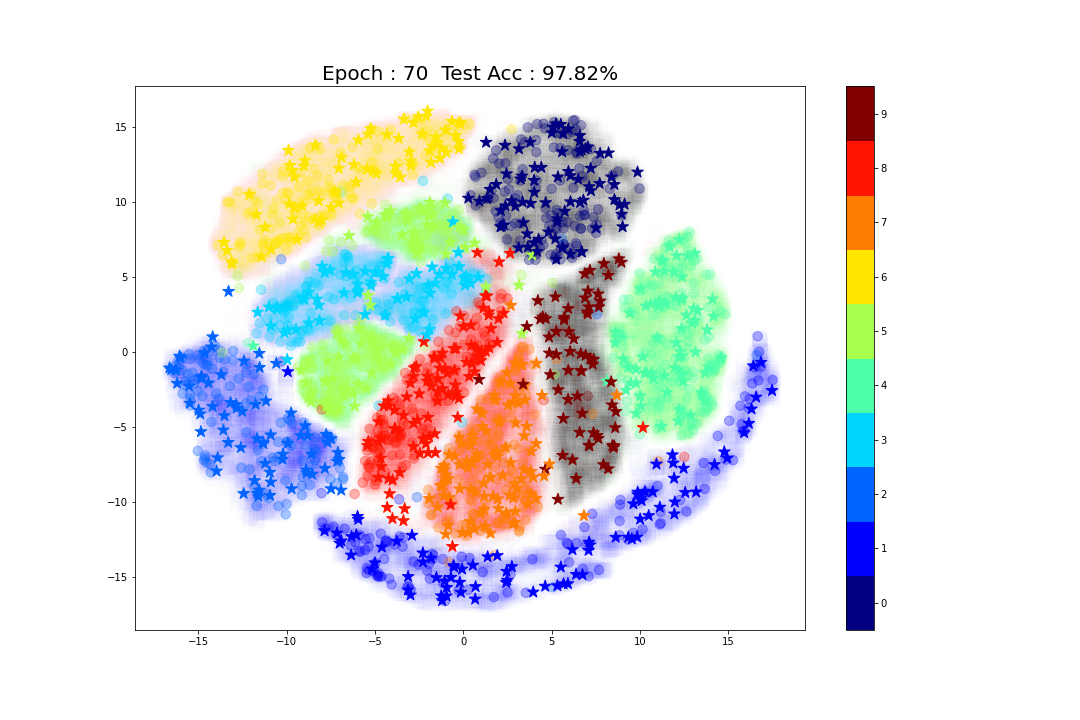

/content/imgs/tsne3072.png


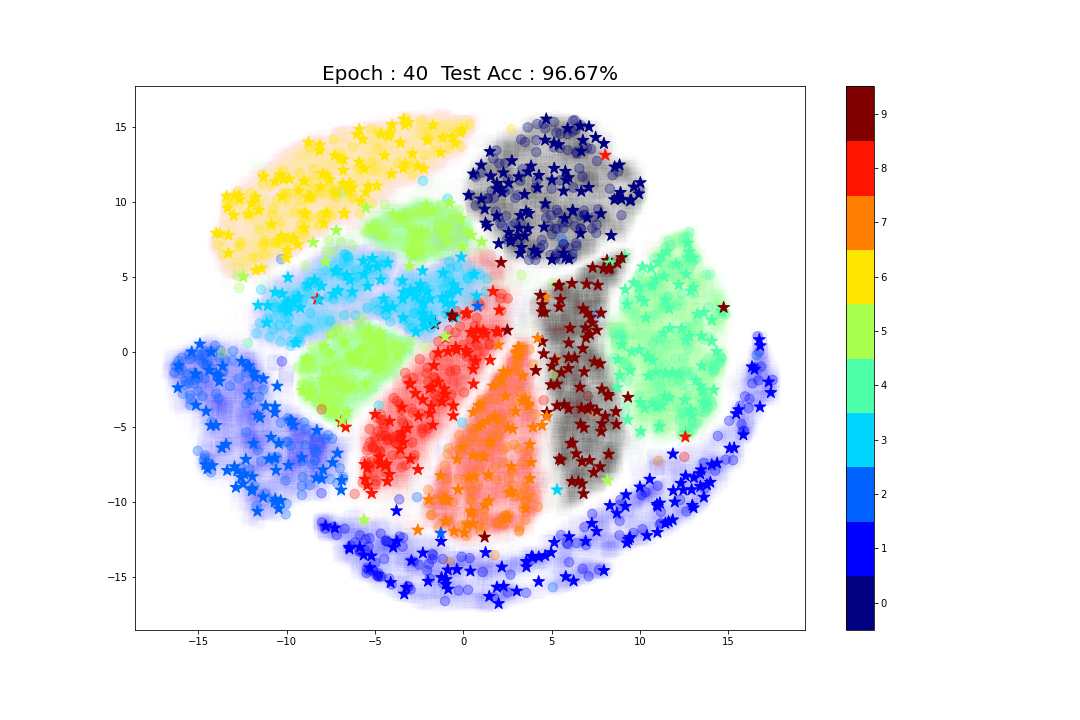

/content/imgs/tsne8448.png


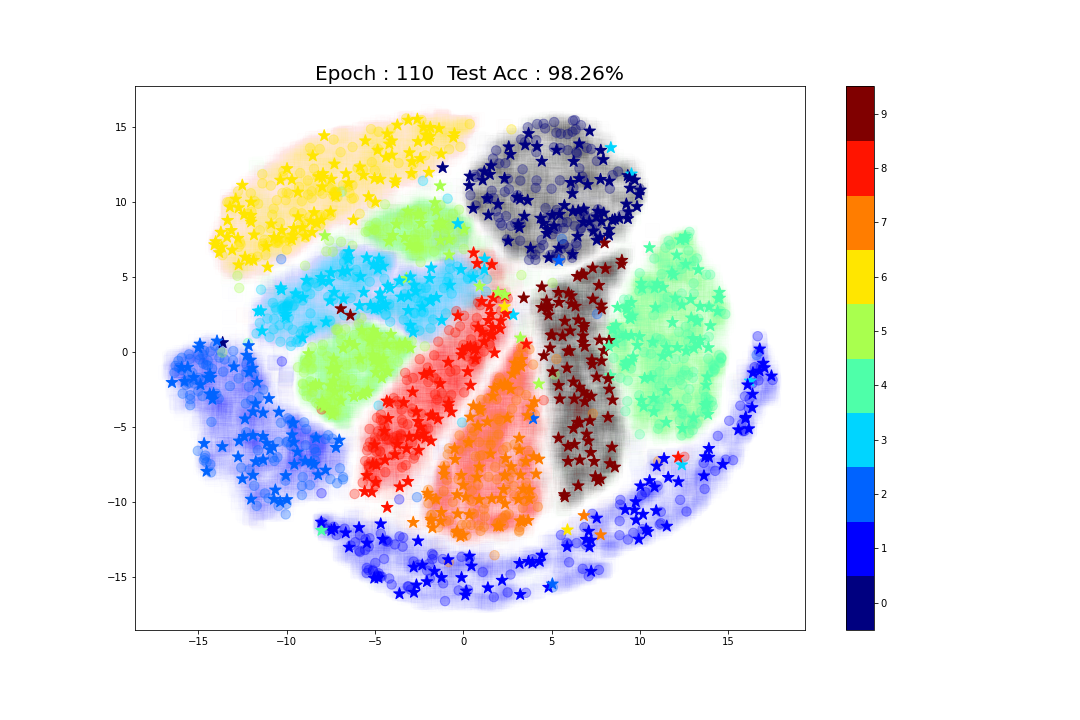

/content/imgs/tsne6144.png


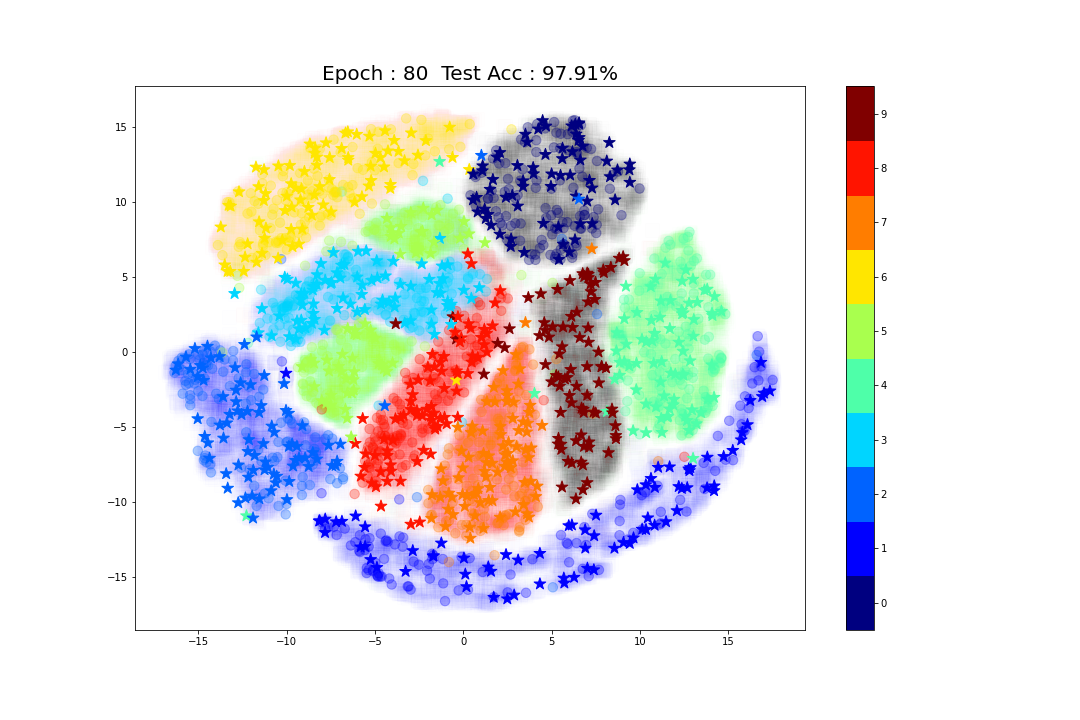

/content/imgs/tsne1536.png


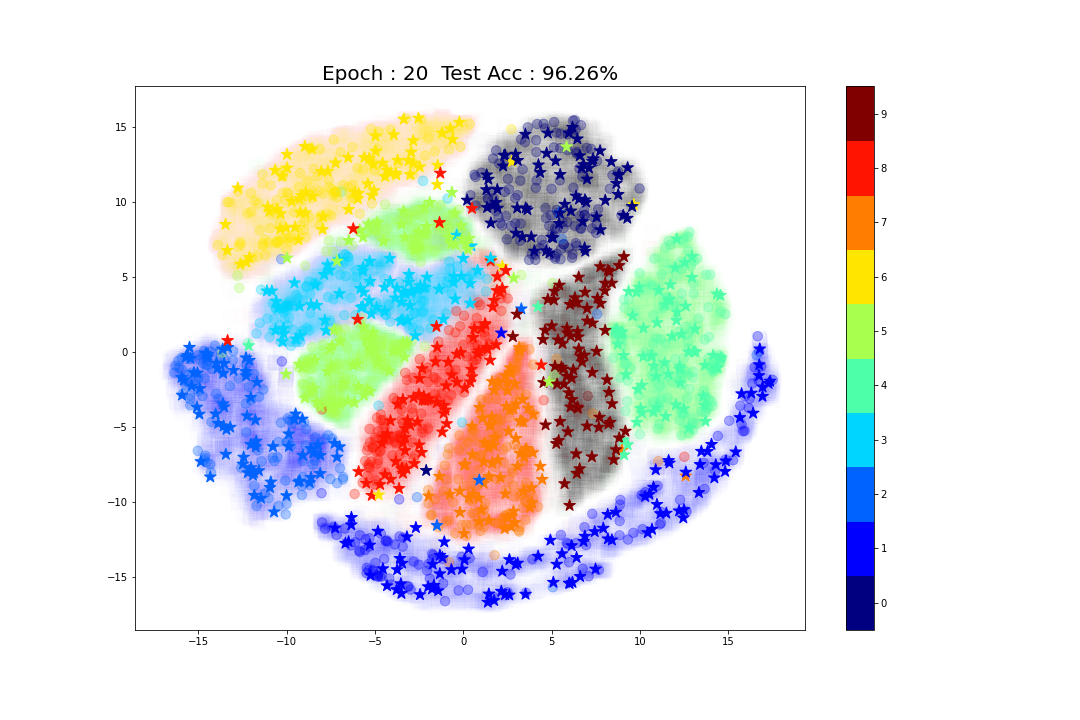

/content/imgs/tsne10752.png


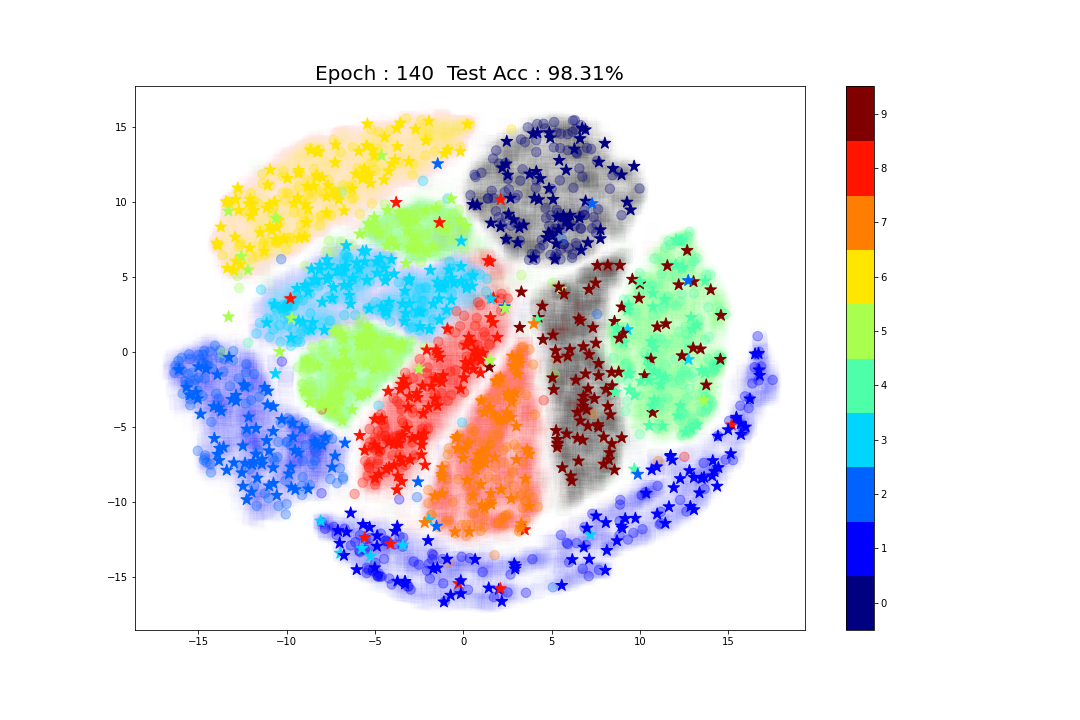

/content/imgs/tsne9984.png


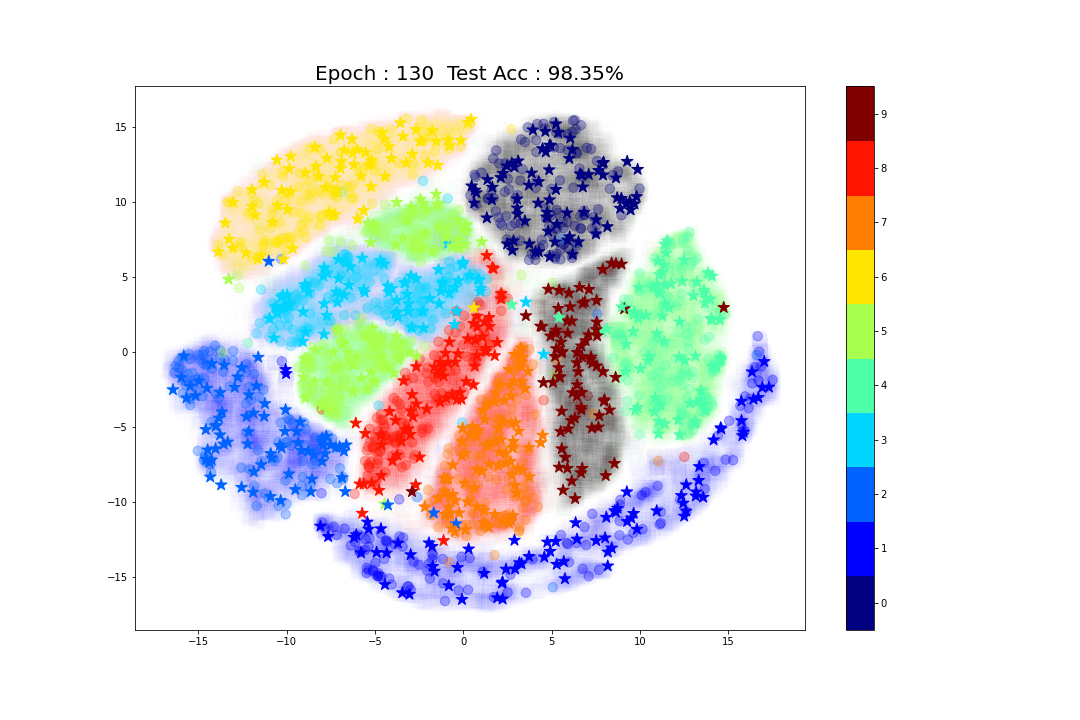

/content/imgs/tsne0.png


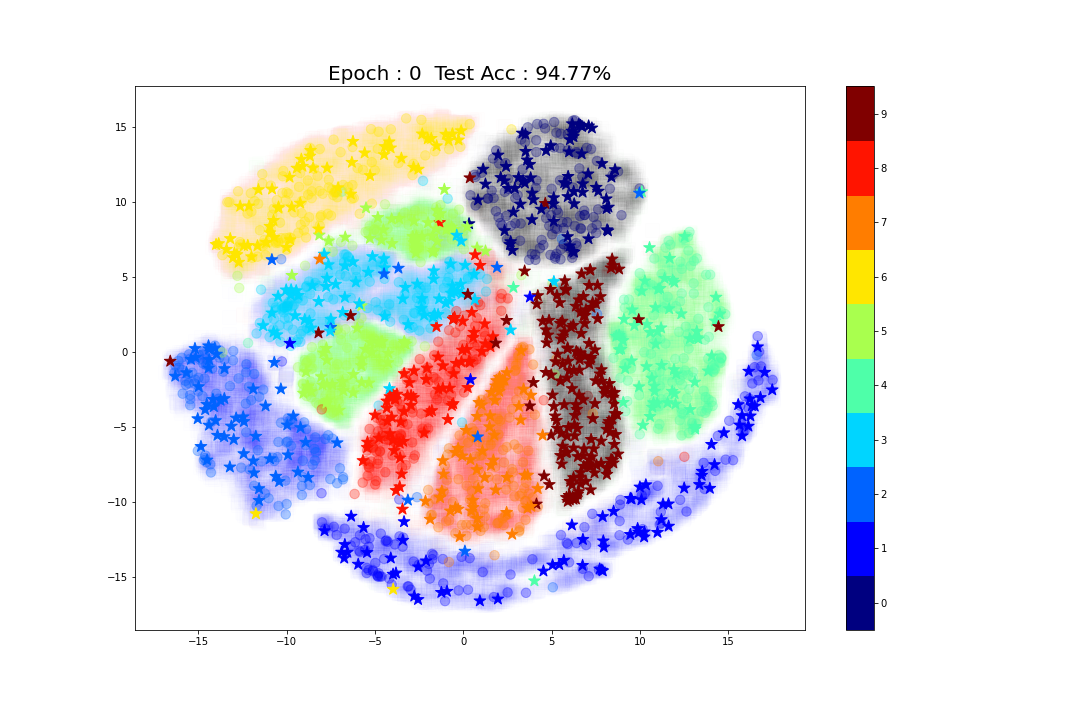

/content/imgs/tsne768.png


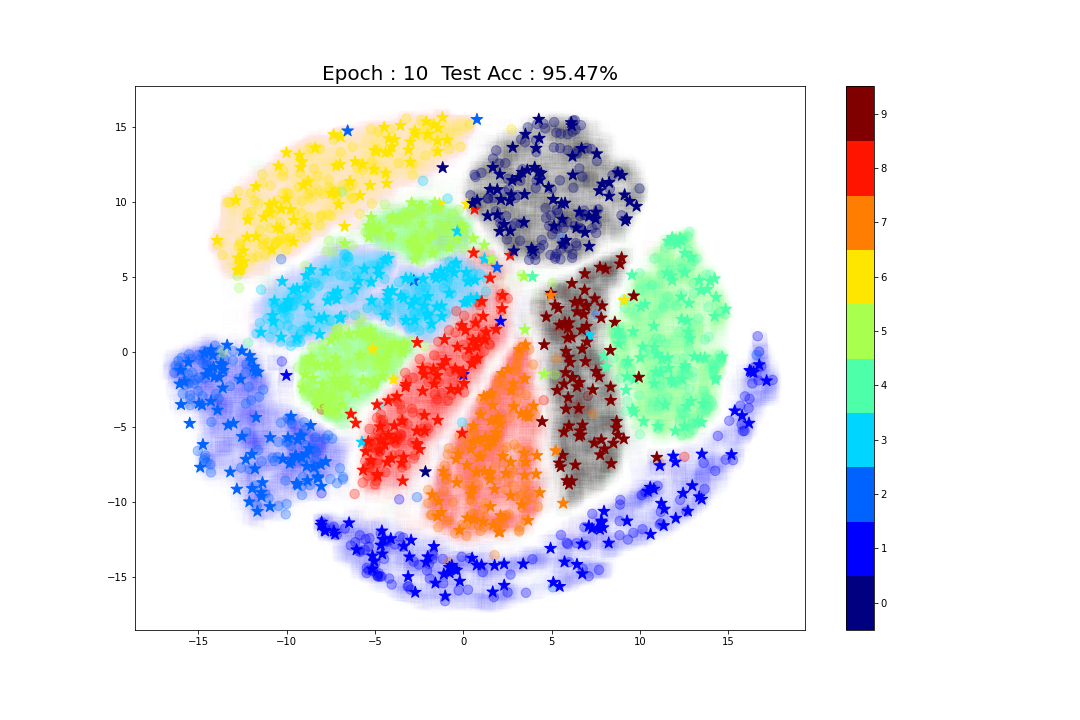

/content/imgs/tsne6912.png


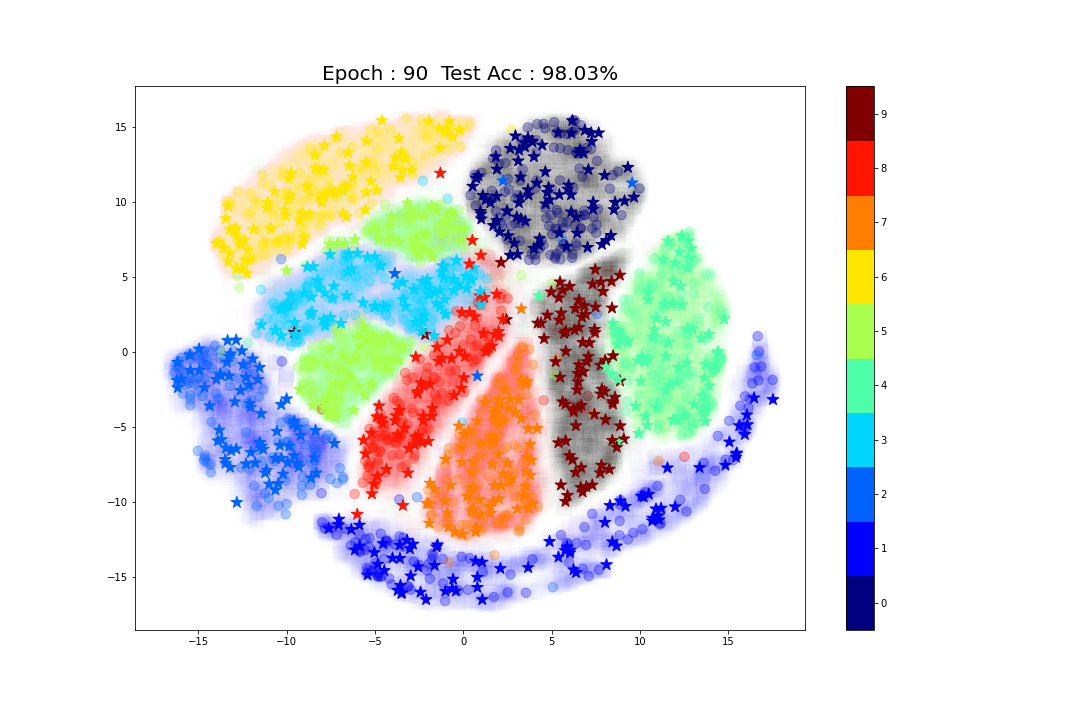

/content/imgs/tsne7680.png


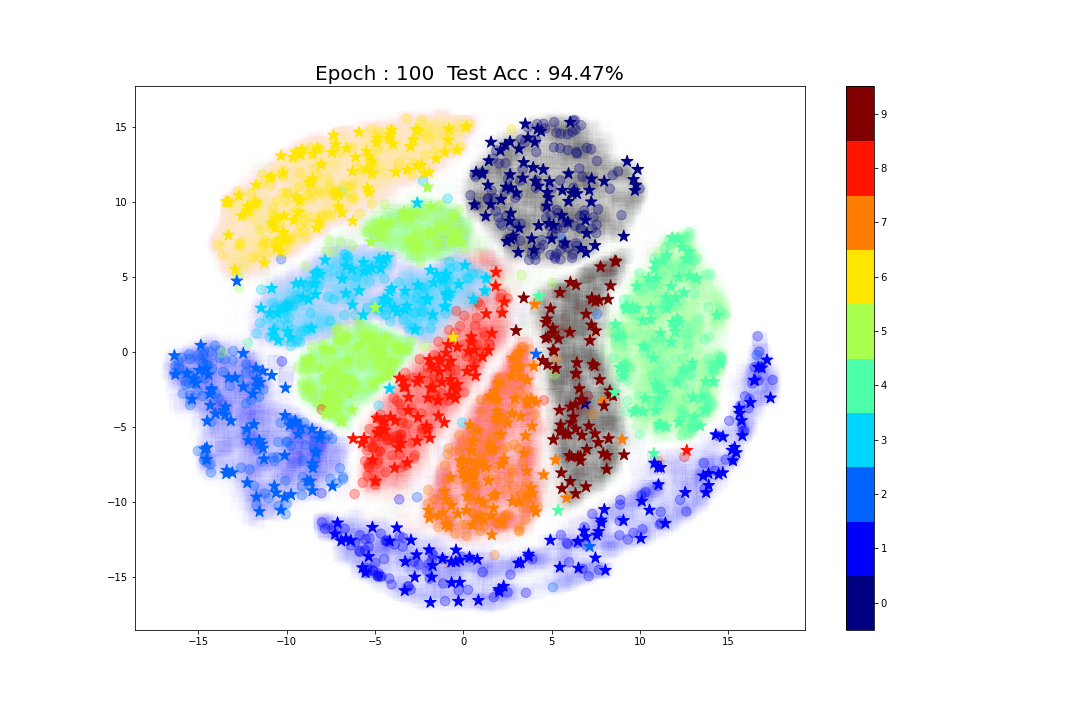

/content/imgs/tsne9216.png


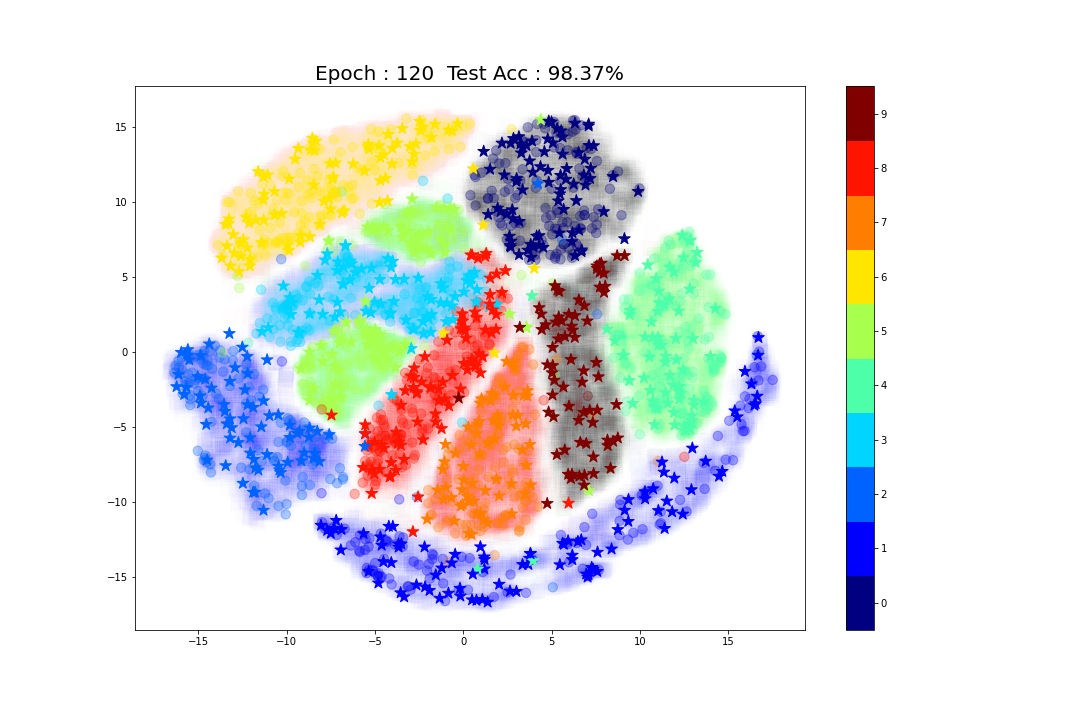

/content/imgs/tsne4608.png


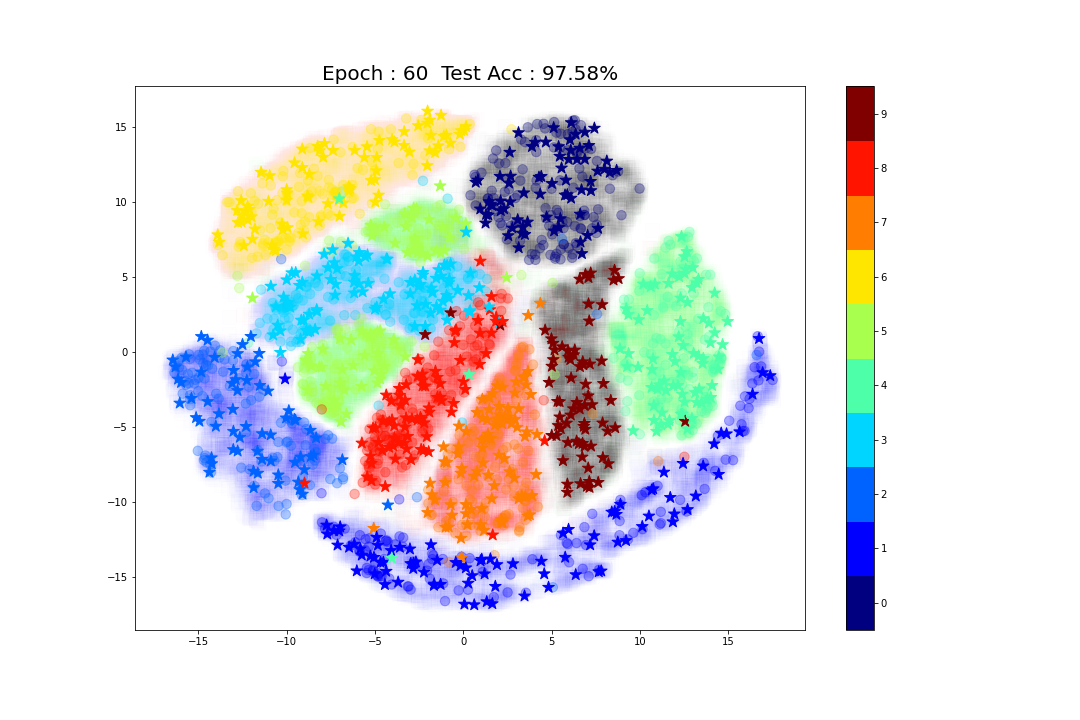

/content/imgs/tsne2304.png


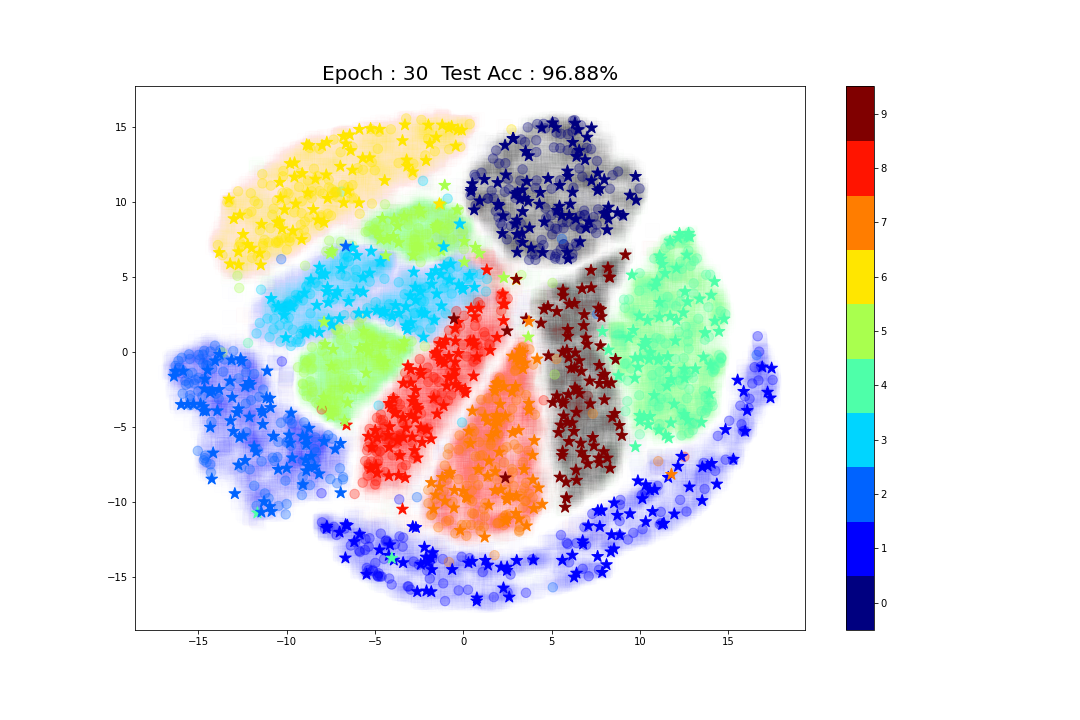

/content/imgs/tsne3840.png


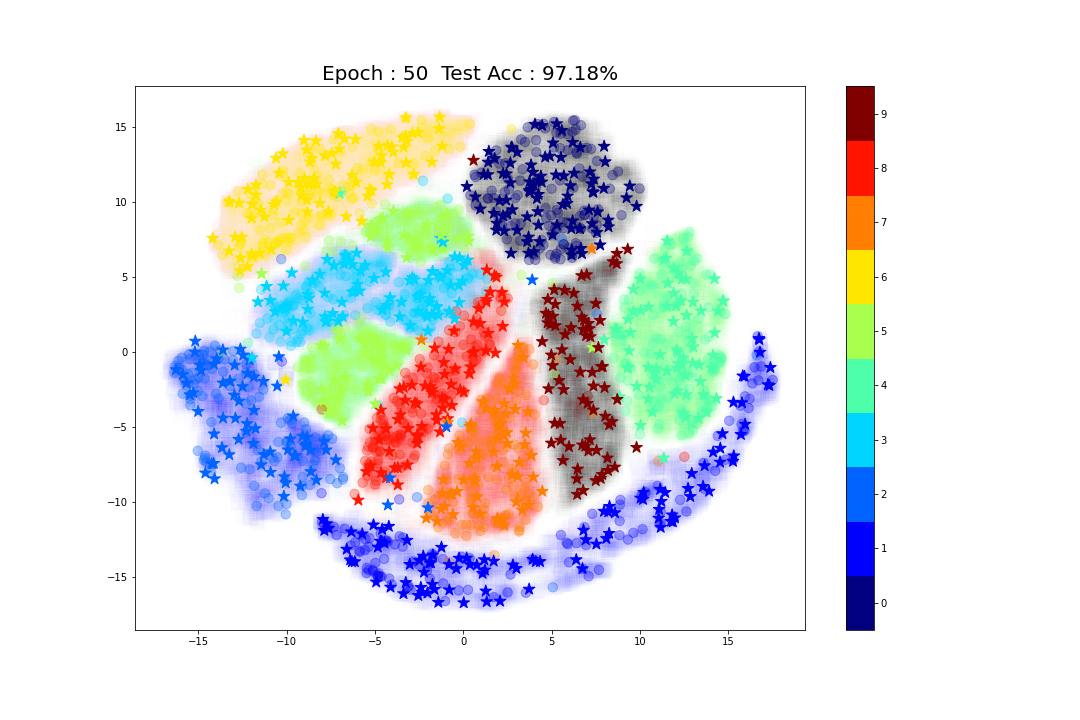

In [ ]:
# from IPython.display import Image
import glob, os
dir = "/content/imgs/"
from IPython.display import Image, display
#display(Image('/content/imgs/tsne0.png'))
for img in glob.glob("/content/imgs/*"):
  print(img)
  display(Image(img))